# 1 - Neural Networks

In the previous exercise, you implemented feedforward propagation for neural
networks and used it to predict handwritten digits with the weights we
provided. In this exercise, you will implement the backpropagation algorithm
to learn the parameters for the neural network.

## 1.1 - Visualizing the data

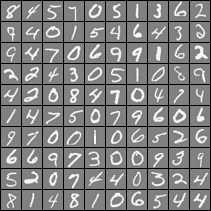

In [1]:
%plot -f svg -w 1000
input_layer_size  = 400;  % 20x20 Input Images of Digits
hidden_layer_size = 25;   % 25 hidden units
num_labels = 10;          % 10 labels, from 1 to 10   
                          % (note that we have mapped "0" to label 10)

addpath('includes/ex4');
load('ex4data1.mat');
m = size(X, 1);

% Randomly select 100 data points to display
sel = randperm(size(X, 1));
sel = sel(1:100);

displayData(X(sel, :));

## 1.2 - Model representation

In [2]:
% Load saved matrices from file
load('ex4weights.mat');

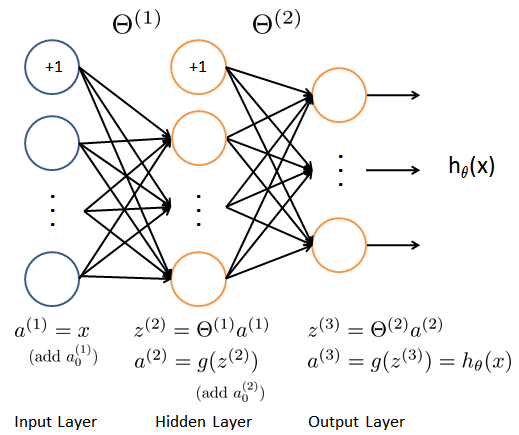

In [3]:
% workaround for octave_kernel.
imshow(im2double(imread('includes/ex4/neural-net-structure.png')))

## 1.3 - Feedforward and Cost function

Our cost function for Neural Networks without regularization is as follows

$$
\begin{align*}
J(\theta) = \frac{1}{m}\sum^m_{i=1}\sum^K_{k=1}\left[-y_k^{(i)}\mbox{log}\left(\left(h_\theta\left(x^{(i)}\right)\right)_k\right) - \left(1-y_k^{(i)}\right)\mbox{log}\left(1-\left(h_\theta\left(x^{(i)}\right)\right)_k\right)\right]
\end{align*}
$$

Where $K = 10$, the amount of possible labels

In [4]:
function g = sigmoid(z)
    g = 1 ./ (1 + exp(-z));
endfunction

In [5]:
function [J grad] = nnCostFunction(nn_params, ...
                        input_layer_size, hidden_layer_size, num_labels, X, y, lambda)
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                     hidden_layer_size, (input_layer_size + 1));
    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                     num_labels, (hidden_layer_size + 1));

    % Setup some useful variables
    m = size(X, 1);

    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));
    
    Y = zeros(m, num_labels);
    for i = 1:m
      Y(i, y(i)) = 1;
    end
    
    X = [ones(m, 1), X];
    a1 = X;
    z2 = a1 * Theta1';
    a2 = [ones(m, 1), sigmoid(z2)];
    z3 = a2 * Theta2';
    a3 = sigmoid(z3);
    
    J = 1 / m * sum(sum((-Y).*log(a3) - (1-Y).*log(1-a3), 2));

    % Unroll gradients
    grad = [Theta1_grad(:) ; Theta2_grad(:)];
endfunction

In [6]:
% We check the cost
nn_params = [Theta1(:) ; Theta2(:)];

% Weight regularization parameter (we set this to 0 here).
lambda = 0;

J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, ...
                   num_labels, X, y, lambda);

fprintf(['Cost at parameters (loaded from ex4weights): %f '...
         '\n(this value should be about 0.287629)\n'], J);

Cost at parameters (loaded from ex4weights): 0.287629 
(this value should be about 0.287629)


## 1.4 Regularized cost function

In [7]:
function [J grad] = nnCostFunction(nn_params, ...
                        input_layer_size, hidden_layer_size, num_labels, X, y, lambda)
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                     hidden_layer_size, (input_layer_size + 1));
    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                     num_labels, (hidden_layer_size + 1));

    % Setup some useful variables
    m = size(X, 1);

    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));
    
    Y = zeros(m, num_labels);
    for i = 1:m
      Y(i, y(i)) = 1;
    end
    
    X = [ones(m, 1), X];
    a1 = X';
    z1 = Theta1*a1;
    a2 = [ones(1, m); sigmoid(z1)];
    z2 = Theta2*a2;
    a3 = sigmoid(z2);
    hypothesis = a3';
    
    J = 1 / m * sum(sum((-Y).*log(hypothesis) - (1-Y).*log(1-hypothesis), 2)) + ...
        lambda / (2 * m) * (sum(sum(Theta1(:, 2:end).^2)) + sum(sum(Theta2(:, 2:end).^2)));

    % Unroll gradients
    grad = [Theta1_grad(:) ; Theta2_grad(:)];
endfunction

In [8]:
fprintf('\nChecking Cost Function (w/ Regularization) ... \n')

% Weight regularization parameter (we set this to 1 here).
lambda = 1;

J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, ...
                   num_labels, X, y, lambda);

fprintf(['Cost at parameters (loaded from ex4weights): %f '...
         '\n(this value should be about 0.383770)\n'], J);


Checking Cost Function (w/ Regularization) ... 
Cost at parameters (loaded from ex4weights): 0.383770 
(this value should be about 0.383770)


# 2 - Backpropagation

## 2.1 - Sigmoid gradient

The sigmoid gradient is computed as follows

$$
g(z) = \frac{1}{1+e^{-z}}\\
g'(z) = \frac{\partial}{\partial z}g(z) = g(z)(1-g(z))
$$

In [9]:
function g = sigmoidGradient(z)
    g = sigmoid(z) .* (1 - sigmoid(z));
endfunction

In [10]:
fprintf('\nEvaluating sigmoid gradient...\n')

g = sigmoidGradient([-1 -0.5 0 0.5 1]);
fprintf('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ');
fprintf('%f\n', g);


Evaluating sigmoid gradient...
Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
0.196612
0.235004
0.250000
0.235004
0.196612
  


## 2.2 - Random initialization

We use $\epsilon_{init} = 0.12$, to initialize $\Theta$ between $-\epsilon_{init}$ and
$+\epsilon_{init}$

A good strategy to choose $\epsilon$ is
$$
\epsilon = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}
$$

In [11]:
function W = randInitializeWeights(L_in, L_out)
    epsilon_init = 0.12;
    W = rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init;
endfunction

In [12]:
printf('\nInitializing Neural Network Parameters ...\n')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size);
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels);

% Unroll parameters
initial_nn_params = [initial_Theta1(:) ; initial_Theta2(:)];


Initializing Neural Network Parameters ...


## 2.3 Backpropagation

In [13]:
function [J grad] = nnCostFunction(nn_params, ...
                        input_layer_size, hidden_layer_size, num_labels, X, y, lambda)
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                     hidden_layer_size, (input_layer_size + 1));
    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                     num_labels, (hidden_layer_size + 1));

    % Setup some useful variables
    m = size(X, 1);

    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));
    
    Y = zeros(m, num_labels);
    for i = 1:m
      Y(i, y(i)) = 1;
    end
    
    X = [ones(m, 1), X];
    a1 = X;
    z2 = a1 * Theta1';
    a2 = [ones(m, 1), sigmoid(z2)];
    z3 = a2 * Theta2';
    a3 = sigmoid(z3);
    
    J = 1 / m * sum(sum((-Y).*log(a3) - (1-Y).*log(1-a3), 2)) + ...
        lambda / (2 * m) * (sum(sum(Theta1(:, 2:end).^2)) + sum(sum(Theta2(:, 2:end).^2)));
        
    delta3 = a3 - Y;
    delta2 = delta3 * Theta2 .* sigmoidGradient([ones(m, 1), z2]);
    delta2 = delta2(:, 2:end);
    
    Theta1_grad = 1 / m * (delta2' * a1);
    Theta2_grad = 1 / m * (delta3' * a2);

    % Unroll gradients
    grad = [Theta1_grad(:) ; Theta2_grad(:)];
endfunction

## 2.4 - Gradient checking

In order to check the derivatives (gradients) we compute a numerical approximation of the derivative.
$$
\mbox{Let  } \theta^{i+} = \theta + \begin{bmatrix}
       0 \\
       0 \\
       \vdots \\
       \epsilon \\
       \vdots \\
       0 \\
     \end{bmatrix}\space\mbox{ and  }\theta^{i-} = \theta - \begin{bmatrix}
       0 \\
       0 \\
       \vdots \\
       \epsilon \\
       \vdots \\
       0 \\
     \end{bmatrix}\\
     \mbox{Where }\epsilon\mbox{ is a small value (e.g. } 10^{-4}\mbox{) and is the ith element. We can compute the approximation as}\\
     \frac{\partial}{\partial\theta_i}J(\theta)\approx\frac{J\left(\theta^{i+}\right) - J\left(\theta^{i-}\right)}{2\epsilon}
$$

In [14]:
fprintf('\nChecking Backpropagation... \n');

%  Check gradients by running checkNNGradients
checkNNGradients;


Checking Backpropagation... 
  -9.2783e-03  -9.2783e-03
   8.8991e-03   8.8991e-03
  -8.3601e-03  -8.3601e-03
   7.6281e-03   7.6281e-03
  -6.7480e-03  -6.7480e-03
  -3.0498e-06  -3.0498e-06
   1.4287e-05   1.4287e-05
  -2.5938e-05  -2.5938e-05
   3.6988e-05   3.6988e-05
  -4.6876e-05  -4.6876e-05
  -1.7506e-04  -1.7506e-04
   2.3315e-04   2.3315e-04
  -2.8747e-04  -2.8747e-04
   3.3532e-04   3.3532e-04
  -3.7622e-04  -3.7622e-04
  -9.6266e-05  -9.6266e-05
   1.1798e-04   1.1798e-04
  -1.3715e-04  -1.3715e-04
   1.5325e-04   1.5325e-04
  -1.6656e-04  -1.6656e-04
   3.1454e-01   3.1454e-01
   1.1106e-01   1.1106e-01
   9.7401e-02   9.7401e-02
   1.6409e-01   1.6409e-01
   5.7574e-02   5.7574e-02
   5.0458e-02   5.0458e-02
   1.6457e-01   1.6457e-01
   5.7787e-02   5.7787e-02
   5.0753e-02   5.0753e-02
   1.5834e-01   1.5834e-01
   5.5924e-02   5.5924e-02
   4.9162e-02   4.9162e-02
   1.5113e-01   1.5113e-01
   5.3697e-02   5.3697e-02
   4.7146e-02   4.7146e-02
   1.4957e-01   1.4957e-0

## 2.5 - Regularized Neural Networks

The regularization equations are as follows

$$
\begin{align*}
\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta)&=\frac{1}{m}\Delta^{(l)}_{ij} &\mbox{for } j=0\\
\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta)&=\frac{1}{m}\Delta^{(l)}_{ij} + \frac{\lambda}{m}\Theta^{(l)}_{ij} &\mbox{for } j\geq1\\
\end{align*}
$$

In [15]:
function [J grad] = nnCostFunction(nn_params, ...
                        input_layer_size, hidden_layer_size, num_labels, X, y, lambda)
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                     hidden_layer_size, (input_layer_size + 1));
    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                     num_labels, (hidden_layer_size + 1));

    % Setup some useful variables
    m = size(X, 1);

    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));
    
    Y = zeros(m, num_labels);
    for i = 1:m
      Y(i, y(i)) = 1;
    end
    
    X = [ones(m, 1), X];
    a1 = X;
    z2 = a1 * Theta1';
    a2 = [ones(m, 1), sigmoid(z2)];
    z3 = a2 * Theta2';
    a3 = sigmoid(z3);
    
    J = 1 / m * sum(sum((-Y).*log(a3) - (1-Y).*log(1-a3), 2)) + ...
        lambda / (2 * m) * (sum(sum(Theta1(:, 2:end).^2)) + sum(sum(Theta2(:, 2:end).^2)));
        
    delta3 = a3 - Y;
    delta2 = delta3 * Theta2 .* sigmoidGradient([ones(m, 1), z2]);
    delta2 = delta2(:, 2:end);
    
    Theta1_grad = 1 / m * (delta2' * a1) + lambda / m * [zeros(hidden_layer_size, 1) Theta1(:, 2:end)];
    Theta2_grad = 1 / m * (delta3' * a2) + lambda / m * [zeros(num_labels, 1) Theta2(:, 2:end)];

    % Unroll gradients
    grad = [Theta1_grad(:) ; Theta2_grad(:)];
endfunction

In [16]:
fprintf('\nChecking Backpropagation (w/ Regularization) ... \n')

%  Check gradients by running checkNNGradients
lambda = 3;
checkNNGradients(lambda);

% Also output the costFunction debugging values
debug_J  = nnCostFunction(nn_params, input_layer_size, ...
                          hidden_layer_size, num_labels, X, y, lambda);

fprintf(['\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' ...
         '\n(for lambda = 3, this value should be about 0.576051)\n\n'], lambda, debug_J);


Checking Backpropagation (w/ Regularization) ... 
  -9.2783e-03  -9.2783e-03
   8.8991e-03   8.8991e-03
  -8.3601e-03  -8.3601e-03
   7.6281e-03   7.6281e-03
  -6.7480e-03  -6.7480e-03
  -1.6768e-02  -1.6768e-02
   3.9433e-02   3.9433e-02
   5.9336e-02   5.9336e-02
   2.4764e-02   2.4764e-02
  -3.2688e-02  -3.2688e-02
  -6.0174e-02  -6.0174e-02
  -3.1961e-02  -3.1961e-02
   2.4923e-02   2.4923e-02
   5.9772e-02   5.9772e-02
   3.8641e-02   3.8641e-02
  -1.7370e-02  -1.7370e-02
  -5.7566e-02  -5.7566e-02
  -4.5196e-02  -4.5196e-02
   9.1459e-03   9.1459e-03
   5.4610e-02   5.4610e-02
   3.1454e-01   3.1454e-01
   1.1106e-01   1.1106e-01
   9.7401e-02   9.7401e-02
   1.1868e-01   1.1868e-01
   3.8193e-05   3.8193e-05
   3.3693e-02   3.3693e-02
   2.0399e-01   2.0399e-01
   1.1715e-01   1.1715e-01
   7.5480e-02   7.5480e-02
   1.2570e-01   1.2570e-01
  -4.0759e-03  -4.0759e-03
   1.6968e-02   1.6968e-02
   1.7634e-01   1.7634e-01
   1.1313e-01   1.1313e-01
   8.6163e-02   8.6163e-02
   1

## 2.6 - Learn parameters


In [17]:
fprintf('\nTraining Neural Network... \n')

%  After you have completed the assignment, change the MaxIter to a larger
%  value to see how more training helps.
options = optimset('MaxIter', 50);

%  You should also try different values of lambda
lambda = 1;

% Create "short hand" for the cost function to be minimized
costFunction = @(p) nnCostFunction(p, ...
                                   input_layer_size, ...
                                   hidden_layer_size, ...
                                   num_labels, X, y, lambda);

% Now, costFunction is a function that takes in only one argument (the
% neural network parameters)
[nn_params, cost] = fmincg(costFunction, initial_nn_params, options);

% Obtain Theta1 and Theta2 back from nn_params
Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                 hidden_layer_size, (input_layer_size + 1));

Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                 num_labels, (hidden_layer_size + 1));


Training Neural Network... 
Iteration    50 | Cost: 4.967718e-01


# 3 - Visualizing the hidden layer

One way to understand what your neural network is learning is to visualize
what the representations captured by the hidden units


Visualizing Neural Network... 


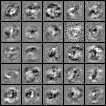

In [18]:
fprintf('\nVisualizing Neural Network... \n')

displayData(Theta1(:, 2:end));

In [19]:
pred = predict(Theta1, Theta2, X);

fprintf('\nTraining Set Accuracy: %f\n', mean(double(pred == y)) * 100);


Training Set Accuracy: 95.020000
